Idea behind SVD localization is to use the leading directions of the sample correlation of a coarse but large ensemble of $X$ as the leading directions of the small but fine ensemble of $Z$.
$$
C_X = \mbox{corr}(X)
$$

$$
U S V^{T} = C_X
$$

This is on a coarse scale and must be interpolated to the finer $Z$ scale resulting in $\tilde{V}$.

$$
C_Z = \mbox{corr}(Z)
$$

$$
C_{Z}^{\parallel} = \tilde{V} \mbox{diag}( \mbox{diag}( \tilde{V}^T C_Z \tilde{V} ) ) \tilde{V}^T
$$

$$
C_{Z}^{\bot} = C_Z - C_Z^{\parallel}
$$

$$
C_{Z}^{loc} = C_Z^{\parallel} + C_{\rho} \circ C_Z^{\bot}
$$

$$
P_Z^{loc} = D^{1/2} C_Z^{loc} D^{1/2}
$$

Where $C_{\rho}$ is a localization matrix for the fine scale correlation function, and $D$ is a diagonal matrix with the sample vairance of $Z$ on the diagonal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import importlib


In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline
def imshow(X, title=None, vmin=None, vmax=None, cmap=None, dpi=None):
    plt.figure(dpi=dpi)
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [4]:
importlib.reload(covariance)

  

<module 'multi_loc.covariance' from '/Users/harty/Documents/python_code/multi_loc/multi_loc/covariance.py'>

In [5]:
Nz = 2**9
rho0_l = 0.2
rho0_s = 0.002
coarse = 8
R_var = 1

dz = 1/Nz
z = np.arange(Nz)

Hz = np.eye(Nz)[::4]
Ny = Hz.shape[0]
y = Hz @ z

Nx = Nz // coarse
dx = dz * coarse
Sz2x = np.eye(Nz)[::coarse]
Sx2z = utilities.lin_interp_matrix(Nz, coarse)

Hx = Hz @ Sx2z
x = Sz2x @ z

In [6]:
# a_l = 0.6
# Pz = covariance.two_scale_circulant(Nz, dz, rho0_l, rho0_s, a_l, covariance.fft_sqd_exp_1d)

l_max = 0.9
l_min = 0.2
var = 8 * Nz
zz = np.arange(Nz) - (Nz - 1)/2
std_l = 1 - np.exp(-(zz)**2/(2 * var))
std_l = (std_l - std_l.min())/(std_l.max() - std_l.min())
std_l = std_l * (l_max - l_min) + l_min
std_l = np.sqrt(std_l)
Pz = covariance.two_scale_hetero(Nz, dz, rho0_l, rho0_s, covariance.fft_sqd_exp_1d, std_l)

In [7]:
R = R_var * np.eye(Ny)

Lam_z, Qz = np.linalg.eigh(Pz)
Lam_z = Lam_z[::-1]
Qz = Qz[:, ::-1]

Px = Pz[::coarse, ::coarse]
Lam_x, Qx = np.linalg.eigh(Px)
Lam_x = Lam_x[::-1]
Qx = Qx[:, ::-1]

trans_mats_true = assimilate.transformation_matrices(
    Hz, P=Pz,
    R=R, return_Ts=True)
for key, val in trans_mats_true.items():
    exec(key + 'z=val')

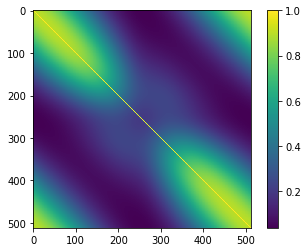

In [8]:
imshow(Pz)

In [9]:
Nez = 40
mu_z = np.random.multivariate_normal(np.zeros(Nz), Pz)
Zens = assimilate.generate_ensemble(Nez, mu_z, P_sqrtz)

In [10]:
Zobs = Hz @ mu_z
Zobs = Zobs[:, None] + np.random.multivariate_normal(np.zeros(Ny), R, Nez).T

In [11]:
def KF(Z, Zobs, Pz, H, R):
    K = Pz @ H.T @ np.linalg.pinv(H @ Pz @ H.T + R)
    Za = Z + K @ (Zobs - H @ Z)
    return Za

# Using actual Pz

In [12]:
Za_Pz = KF(Zens, Zobs, Pz, Hz, R)
mu_Pz = np.mean(Za_Pz, axis=1)
rmse_Pz = np.sqrt(((mu_z - mu_Pz)**2).mean())
print('Pz rmse: ', rmse_Pz)

Pz rmse:  0.08165940484414923


# Using actual Qz

In [13]:
Pz_sam = np.cov(Zens)
Pz_Qz = (Qz
         @ np.diag(np.diag(
             Qz.T @ Pz_sam @ Qz))
         @ Qz.T)
Za_Qz = KF(Zens, Zobs, Pz_Qz, Hz, R)
mu_Qz = np.mean(Za_Qz, axis=1)
rmse_Qz = np.sqrt(((mu_z - mu_Qz)**2).mean())
print('Qz rmse: ', rmse_Qz)

Qz rmse:  0.082289509558535


# Using no localization

In [14]:
Za_sam = KF(Zens, Zobs, Pz_sam, Hz, R)
mu_sam = np.mean(Za_sam, axis=1)
rmse_sam = np.sqrt(((mu_z - mu_sam)**2).mean())
print('sam rmse: ', rmse_sam)

sam rmse:  0.10768796720073266


# Using tuned standard localization

In [15]:
def assimilate_stdrd(Zens, Zobs, Hz, R, Pz_sam, rho0_loc_s):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = L_s * Pz_sam
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [16]:
loc_array_stdrd = np.linspace(0.00001, 0.3, 100)
rmse_stdrd = loc_array_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_stdrd(Zens, Zobs, Hz, R, Pz_sam, a_rho0)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_stdrd[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Standard loc RMSE:  0.09141493753151632


Text(0.5, 1.0, 'Comparison of different methods')

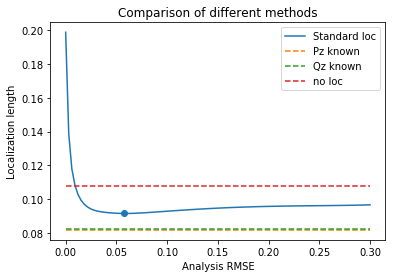

In [17]:
arg_min = np.argmin(rmse_stdrd)
rmse_stdrd_min = rmse_stdrd[arg_min]
opt_stdrd = loc_array_stdrd[arg_min]
print('Standard loc RMSE: ', rmse_stdrd_min)
plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Standard loc',
            'Pz known',
            'Qz known',
            'no loc'])
plt.title('Comparison of different methods')

# Using perfect initial directions (no secondary localization)

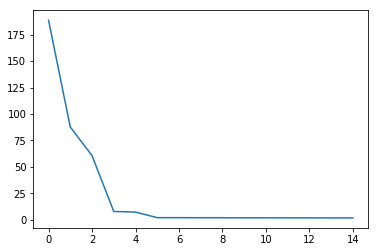

In [18]:
plt.figure()
plt.plot(Lam_z[:15])

In [19]:
sig_num = 5
Qzl = Qz[:, :sig_num]
Pz_Qzl = (Qzl
         @ np.diag(np.diag(
             Qzl.T @ Pz_sam @ Qzl))
         @ Qzl.T)
Za_Qzl = KF(Zens, Zobs, Pz_Qzl, Hz, R)
mu_Qzl = np.mean(Za_Qzl, axis=1)
rmse_Qzl = np.sqrt(((mu_z - mu_Qzl)**2).mean())
print('Qzl rmse: ', rmse_Qz)

Qzl rmse:  0.082289509558535


# Perfect eig localization (tuned seconday loc)

In [20]:
def assimilate_eig(Zens, Zobs, Hz, R, Pz_Qzl, Pz_orth, rho0_loc_s):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = Pz_Qzl + L_s * Pz_orth
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [21]:
Pz_orth = Pz_sam - Pz_Qzl
rmse_eig = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig(Zens, Zobs, Hz, R, Pz_Qzl, Pz_orth, a_rho0)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Eigenvalue loc RMSE:  0.08441456366685711


(0.075, 0.2)

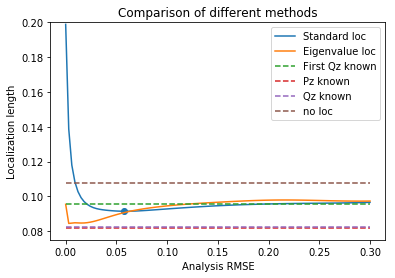

In [22]:
arg_min = np.argmin(rmse_eig)
rmse_eig_min = rmse_eig[arg_min]
opt_eig = loc_array_stdrd[arg_min]
print('Eigenvalue loc RMSE: ', rmse_eig_min)
plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Standard loc',
            'Eigenvalue loc',
            'First Qz known',
            'Pz known',
            'Qz known',
            'no loc'])
plt.title('Comparison of different methods')
plt.ylim([0.075, 0.2])

# Perfect eig localization (tuned seconday loc; projection)

In [23]:
def assimilate_eig_proj(Zens, Zobs,
                        Hz, R, Pz_Qzl,
                        Pz_orth, rho0_loc_s, Proj):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = Pz_Qzl + Proj @ (L_s * Pz_orth) @ Proj
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [24]:
Proj = np.eye(Nz) - Qzl @ Qzl.T
Pz_orth_proj = Proj @ Pz_sam @ Proj
rmse_eig_proj = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig_proj(Zens, Zobs, Hz, R, Pz_Qzl, Pz_orth_proj, a_rho0, Proj)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig_proj[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Eigenvalue loc RMSE:  0.08441456366685711


(0, 0.1)

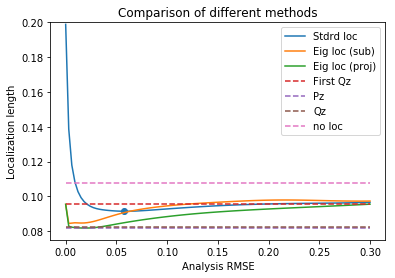

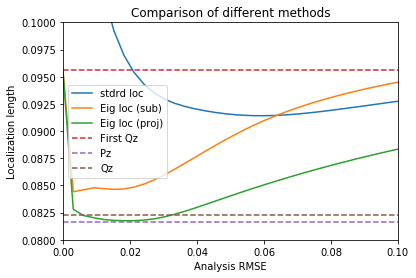

In [27]:
arg_min = np.argmin(rmse_eig)
rmse_eig_min = rmse_eig[arg_min]
opt_eig = loc_array_stdrd[arg_min]
print('Eigenvalue loc RMSE: ', rmse_eig_min)

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Stdrd loc',
            'Eig loc (sub)',
            'Eig loc (proj)',
            'First Qz',
            'Pz',
            'Qz',
            'no loc'])
plt.title('Comparison of different methods')
plt.ylim([0.075, 0.2])


plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['stdrd loc',
            'Eig loc (sub)',
            'Eig loc (proj)',
            'First Qz',
            'Pz',
            'Qz'])
plt.title('Comparison of different methods')
plt.ylim([0.08, 0.1])
plt.xlim([0, 0.1])